In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base() # Declare a Base using `automap_base()`
# reflect the tables
Base.prepare(engine, reflect=True) # Use the Base class to reflect the database tables

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
#There are two classes to be assigned as Measurement and Station
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() #Latest date
last_date


('2017-08-23')

In [11]:
# Calculate the date 1 year ago from the last data point in the database
query_1y_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365) # Assume 1 year period equals to 365 days
print("Query Date:", query_1y_ago)

Query Date: 2016-08-23


In [14]:
#retrieve the last 12 months of precipitation data and plot the results
total_in_1y = (session.query(Measurement.date,func.max(Measurement.prcp))
               .filter(func.strftime('%Y-%m-%d', Measurement.date) > query_1y_ago)
               .group_by(Measurement.date).all())

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_n_Pscores = pd.DataFrame(total_in_1y, columns=['date', 'prcp'])
date_n_Pscores.set_index('date',inplace=True)
date_n_Pscores.head()

,prcp
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07


In [16]:
# Sort the dataframe by date
dnp_df = date_n_Pscores.sort_values('date')

Text(0, 0.5, 'Precipitation (in)')

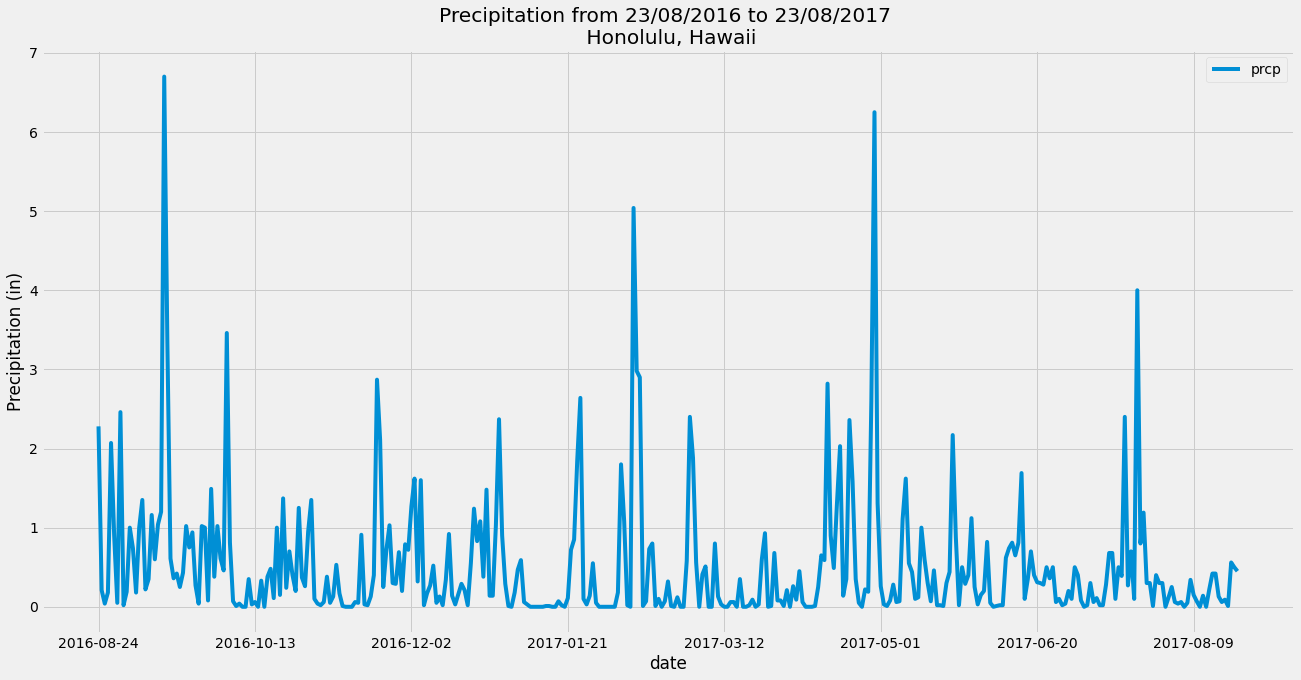

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
dnp_df.plot(figsize=(20,10), title="Precipitation from 23/08/2016 to 23/08/2017 \n Honolulu, Hawaii")
plt.ylabel('Precipitation (in)')

Use Pandas to calcualte the summary statistics for the precipitation data


In [18]:
# drop Null value
date_n_Pscores.dropna()

,prcp
date,
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


In [19]:
date_n_Pscores.describe()

,prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).count()
print(f'Total number of stations: {num_stations}')

Total number of stations: 9


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act_stations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)
               .order_by(func.count(Measurement.station).desc()).all())
act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp = (session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
                      .filter(Measurement.station == 'USC00519281').all())
                     
print(f'{temp} is the Mininmum, Maximum, and Average temperature for the most active station in Honolulu')


[(54.0, 85.0, 71.66378066378067)] is the Mininmum, Maximum, and Average temperature for the most active station in Honolulu


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
year_temp = session.query(Measurement.date,(Measurement.tobs)).\
                                    filter(func.strftime(Measurement.date) > \
                                                query_1y_ago).filter(Measurement.station == 'USC00519281').all()
#year_temp

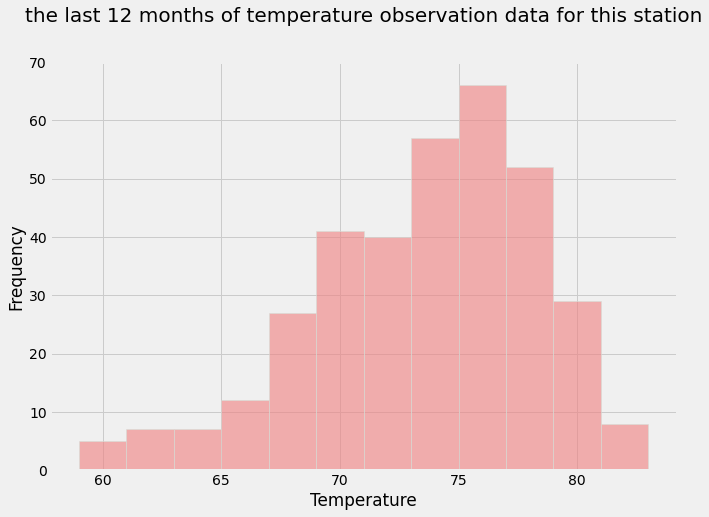

In [24]:
# plot the results as a histogram
year_temp_df = pd.DataFrame(year_temp)
year_temp_df.set_index('date', inplace=True)
plt.rcParams['figure.figsize']=(10,7)
plt.hist(year_temp_df['tobs'],bins=12,alpha=0.6,edgecolor='xkcd:light gray',
         linewidth=1,color='lightcoral')

plt.title('the last 12 months of temperature observation data for this station',fontsize=20,pad=40)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.ylim(0,70)

plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
